#  Python class overload

<!-- SUMMARY: Demonstration of the overload of a class of gstlearn in Python  -->

<!-- CATEGORY: Tools_for_Python_environment -->

The aim of this tutorial is to show how to customize the default behaviour of the **gstlearn** package. The choosen example here shows how to define your own moving neighborhood criteria.

# Initialization

The data file is read from the Distribution as a CSV file and loaded as a Panda Frame.

In [2]:
import pandas as pd
import numpy as np
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import urllib.request
import matplotlib.pyplot as plt

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

In [3]:
datcsv = gdoc.loadData("Scotland", "Scotland_Temperatures.csv")
datcsv = pd.read_csv(datcsv, na_values="MISS")
datcsv

,Longitude,Latitude,Elevation,January_temp
0,372.1,658.9,255,1.7
1,303.5,665.9,125,2.0
2,218.4,597.9,8,4.6
3,245.0,955.0,90,NaN
4,326.8,691.2,32,3.1
...,...,...,...,...
231,273.2,564.6,47,2.8
232,333.9,730.1,30,2.6
233,185.0,655.0,115,NaN
234,259.8,587.9,119,2.1


We create a Db and set the **locators** for the coordinates and the variable of interest.

In [4]:
data = gl.Db()
for field in datcsv.columns :
  data[field] = datcsv[field]
data.setLocators(["Longitude","Latitude"], gl.ELoc.X)
data.setLocator("January_temp", gl.ELoc.Z)
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 236

Variables
---------
Column = 0 - Name = Longitude - Locator = x1
Column = 1 - Name = Latitude - Locator = x2
Column = 2 - Name = Elevation - Locator = NA
Column = 3 - Name = January_temp - Locator = z1

The next plot shows the samples where the variable **January_temp** is defined. Note that, even if the data base contains 236 samples, not all sample present a valid value for the **January_temp** variable: in fact this variable is only measured in 151 samples.

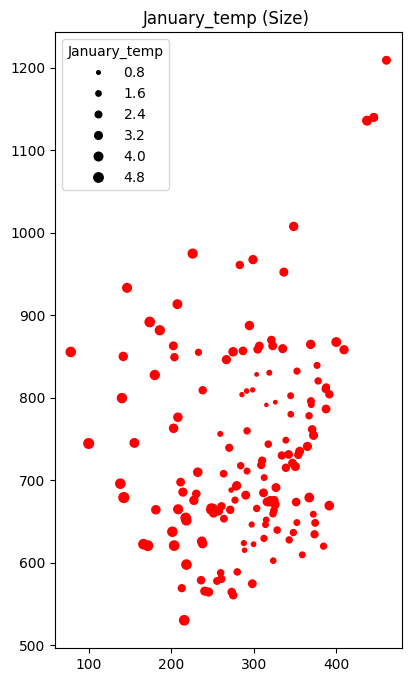

In [5]:
gp.plot(data,nameSize="January_temp",sizmin=5,sizmax=50, flagLegendSize=True)

We create automatically a grid data base covering all the data points. Number of node is choosen by trial/error in order to have more or less an homogeneous mesh size.

In [6]:
grid = gl.DbGrid.createCoveringDb(data, nx=[80,130], margin=[50,50])
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 2
Total number of samples      = 10400

Grid characteristics:
---------------------
Origin :     28.200   480.400
Mesh   :      6.108     6.035
Number :         80       130

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2

# Playing with NeighMoving

We create a moving neighborhood definition object which corresponds to a large search radius and a small maximum number of samples.

In [7]:
nmini = 1
nmaxi = 3
radius = 300 # Big radius
nsect = 1
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect)
neigh


Moving Neighborhood
Minimum number of samples           = 1
Maximum number of samples           = 3
Maximum horizontal distance         = 300

We trigger the moving neighborhood algorithm applied to the target node (of the grid) whose rank is 4511. We obtain three neighbors and display their ranks. 

In [8]:
node = 4511
neigh.attach(data, grid)
ranks = gl.VectorInt()
neigh.select(node, ranks)
ranks # Ranks should be: 23, 75 and 143

[23 75 143]

Here is a small function using ax.neigh gstlearn function that offers the possibility to display neigh results. 

In [9]:
def show_neigh(data, grid, neigh, node, ranks):
  ax = data.plot(nameSize="January_temp",sizmax=30, useSel=True)
  if (ranks.size() > 0):
    dataSel = data.clone()
    dataSel.addSelectionByRanks(ranks)
    ax = dataSel.plot(color='blue',nameSize="January_temp",sizmax=30)
  ax.neigh(neigh, grid, node)
  ax.decoration("Standard Neighborhood")

We use this internal function to display the results of the neighborhood search applied to the target grid node. The target node is in black, the idle samples are in red and the selected samples are in blue. The neighborhood search circle is overlaid.

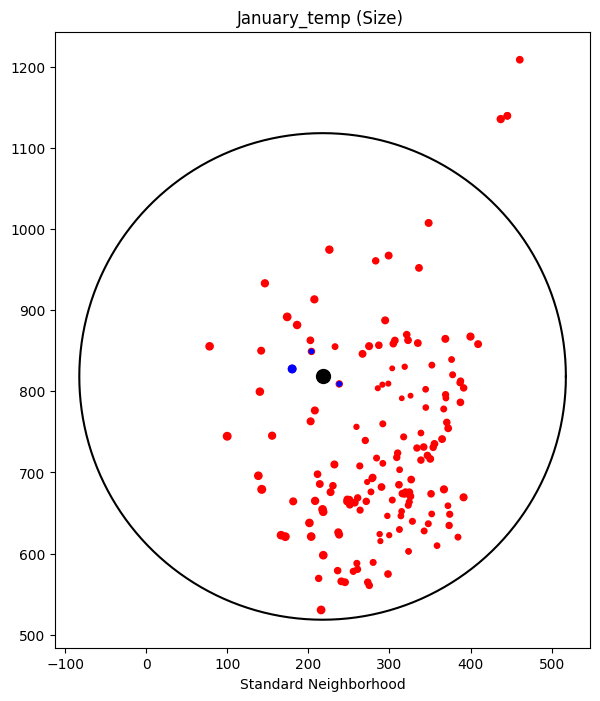

In [10]:
show_neigh(data, grid, neigh, node, ranks)

We reduce the radius of the circle so that only one neighbor will be selected.

In [11]:
nmini = 1
nmaxi = 3
radius = 30 # Smaller radius
nsect = 1
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect)
neigh


Moving Neighborhood
Minimum number of samples           = 1
Maximum number of samples           = 3
Maximum horizontal distance         = 30

For the same target node, this time, only one sample is selected.

In [12]:
node = 4511
neigh.attach(data, grid)
ranks = gl.VectorInt()
neigh.select(node, ranks)
ranks # Only rank 143

[143]

This neighborhood search is illustrated in the next figure.

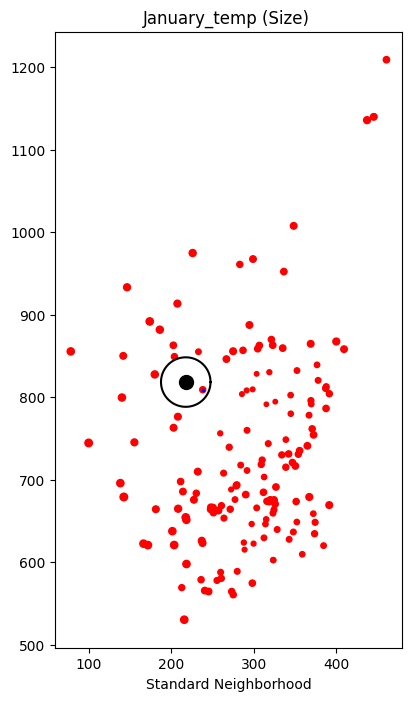

In [13]:
show_neigh(data, grid, neigh, node, ranks)

# Extending the gstlearn

In this pargraph, we want to add our own neighborhood "checker" by defining it in Python. We choose to mimick the maximum radius checker which is already available in the standard *NeighMoving* class.

We create a new class (in Python) that inherits from the **gstlearn** C++ class named *ABiTargetCheck*. In that class, we define a member called *radius* and override three abstract methods:
 - isOK: that returns *True* if two space targets (see SpaceTarget class) are considered in the same neighborhood.
 - toString: that returns the characters string describing the class content.
 - clone: that returns a new instance of the object

In [14]:
class BiTargetCheckMaxRadius(gl.ABiTargetCheck):
    def __init__(self, radius):
        super(BiTargetCheckMaxRadius,self).__init__()
        self.radius = radius
        
    def isOK(self,st1,st2):
        return st1.getDistance(st2) < self.radius

    def toString(self,strfmt):
        return "This is my Max Radius checker: {}".format(self.radius)

    # __disown__ is used to avoid memory leaks
    def clone(self):
        return BiTargetCheckMaxRadius(self.radius).__disown__()

Then, we recreate a NeighMoving object having a big radius (should select 3 neighbors), but we add our customized checker which indicates a small radius. Doing that, we hope that the neighborhood algorithm will select back only one sample (with rank 143).

In [15]:
nmini = 1
nmaxi = 3
radius = 300 # Big radius
neigh2 = gl.NeighMoving.create(False, nmaxi=nmaxi, nmini=nmini,radius=radius)
# Prefer my own maximum radius checker!
btc = BiTargetCheckMaxRadius(30)
neigh2.addBiTargetCheck(btc)
neigh2.display()


Moving Neighborhood
Minimum number of samples           = 1
Maximum number of samples           = 3
Maximum horizontal distance         = 300
This is my Max Radius checker: 30

In [16]:
node = 4511
neigh2.attach(data, grid)
ranks = gl.VectorInt()
neigh2.select(node, ranks)
ranks # Should return 143

[143]

Here, the big ellipsoid circle is shown (default behavior) but only one sample is selected due to our customized checker.

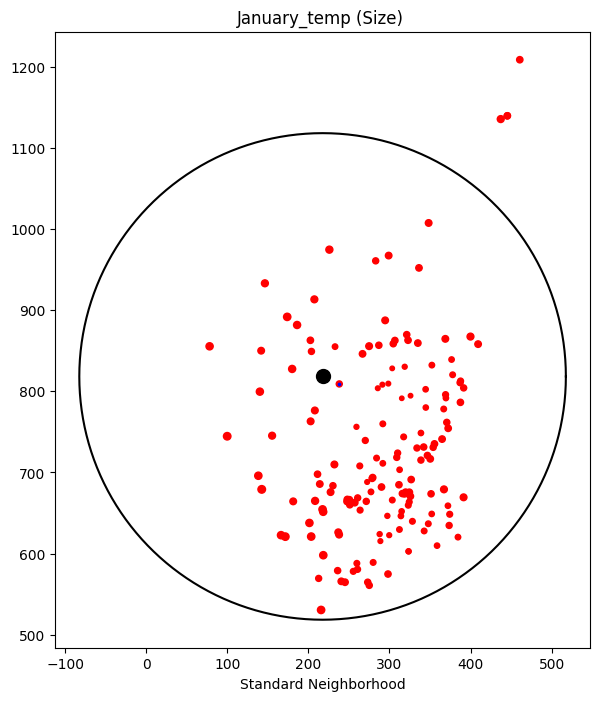

In [17]:
show_neigh(data, grid, neigh2, node, ranks)